# Libraries

In [123]:
# Loading all necessary libraries for the modeling notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.metrics import classification_report, multilabel_confusion_matrix, recall_score, precision_score, confusion_matrix, f1_score, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from transformers import AutoTokenizer, AutoModel, pipeline
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import pipeline
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

from skmultilearn.model_selection import IterativeStratification


In [124]:
# Load dataset
file_path = '/Users/jasont/Downloads/goemotions_gold.csv'
df = pd.read_csv(file_path)

# Display basic info and the first couple rows of data
print("Shape of dataset:", df.shape)
print(df.head())

Shape of dataset: (57732, 41)
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_id  \
0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   

    created_utc  rater_id  example_very_unclear  admiration  ...  realization  \
0  1.548381e+09         1                 False           0  ...            0

In [125]:
# This is to get all the One Hot encoded columns from the data set and set it as the emotion variable
emotion_cols = df.columns[9:-4]  # assuming first 9 are metadata
print("Emotion columns:", emotion_cols.tolist())

Emotion columns: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [126]:
# Creating a clean text function to handle some basic cleaning on the text column
def clean_text(text):
    if pd.isnull(text):
        return ""
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove special characters and digits (optional, keep only words and spaces)
    text = re.sub(r"[^a-zA-Z\s']", ' ', text)
    # Lowercase
    text = text.lower()
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [127]:
#Create a clean_text column by using the function above on the text column
df['clean_text'] = df['text'].apply(clean_text)

# Model 1: Logistic Regression and Linear SVM (Weighted vs. Non-weighted)

In [128]:
# Train Test Split Data
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df[emotion_cols], test_size=0.2, random_state=42)

# Applying TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [129]:
# Define models (weighted and unweighted)
models = {
    "Logistic Regression (Unweighted)": LogisticRegression(max_iter=1000),
    "Logistic Regression (Weighted)": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Linear SVM (Unweighted)": LinearSVC(),
    "Linear SVM (Weighted)": LinearSVC(class_weight='balanced')
}

results = []
per_label_reports = {}
fitted_classifiers = {}

In [130]:
# Train and evaluate the models with One vs Rest Classifier
for name, model in models.items():
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    fitted_classifiers[name] = clf

    # Save predictions for specific models
    if name == "Logistic Regression (Weighted)":
        y_pred_lr_weighted = y_pred

    elif name == "Linear SVM (Weighted)":
        y_pred_svm_weighted = y_pred

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    hamming = hamming_loss(y_test, y_pred)

    results.append({
        'Model': name,
        'Macro F1': round(macro_f1, 4),
        'Micro F1': round(micro_f1, 4),
        'Hamming Loss': round(hamming, 4)
    })

    # Store per-label classification report
    report = classification_report(y_test, y_pred, target_names=emotion_cols, output_dict=True, zero_division=0)
    per_label_df = pd.DataFrame(report).T
    per_label_df = per_label_df.loc[[label for label in emotion_cols if label in per_label_df.index], ["f1-score"]]
    per_label_reports[name] = per_label_df

KeyboardInterrupt: 

In [ ]:
# Display the the Macro/Micro F1 and Hamming Loss Results

results_df = pd.DataFrame(results).sort_values(by='Macro F1', ascending=False)
display(results_df)

,Model,Macro F1,Micro F1,Hamming Loss
1,Logistic Regression (Weighted),0.2921,0.3297,0.0994
3,Linear SVM (Weighted),0.2618,0.3123,0.0873
2,Linear SVM (Unweighted),0.1919,0.2910,0.0416
0,Logistic Regression (Unweighted),0.1246,0.2051,0.0403


Since Logistic Regression (Weighted) is the best performer here, we will choose it as our Baseline model moving forward

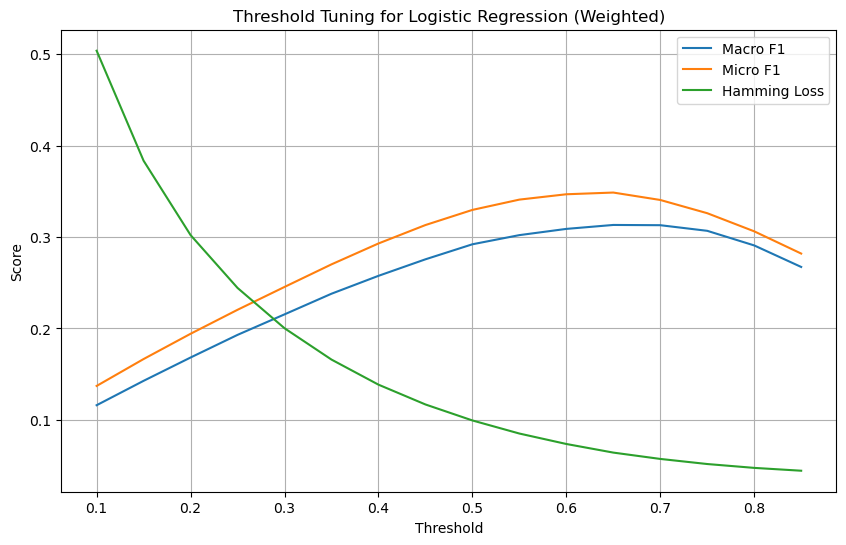

Best Threshold (Macro F1): 0.65
Macro F1: 0.3133
Micro F1: 0.3487
Hamming Loss: 0.0642


In [ ]:
# Below codes are to find the best threshold tunning for the logistic regression (weighted) model
clf_lr_weighted = fitted_classifiers["Logistic Regression (Weighted)"]

# Get predicted probabilities (not labels!)
y_prob = clf_lr_weighted.predict_proba(X_test_tfidf)

# Try a range of thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.9, 0.05)
macro_scores, micro_scores, hamming_losses = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)

    macro_scores.append(f1_score(y_test, y_pred_thresh, average='macro', zero_division=0))
    micro_scores.append(f1_score(y_test, y_pred_thresh, average='micro', zero_division=0))
    hamming_losses.append(hamming_loss(y_test, y_pred_thresh))

# Plot results
plt.figure(figsize=(10,6))
plt.plot(thresholds, macro_scores, label="Macro F1")
plt.plot(thresholds, micro_scores, label="Micro F1")
plt.plot(thresholds, hamming_losses, label="Hamming Loss")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for Logistic Regression (Weighted)")
plt.legend()
plt.grid(True)
plt.show()

# Print the best threshold based on Macro F1
best_idx = np.argmax(macro_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold (Macro F1): {best_threshold:.2f}")
print(f"Macro F1: {macro_scores[best_idx]:.4f}")
print(f"Micro F1: {micro_scores[best_idx]:.4f}")
print(f"Hamming Loss: {hamming_losses[best_idx]:.4f}")

In [ ]:
# Running threshold 0.65 as it is the best threshold)
threshold = 0.65
y_proba = clf_lr_weighted.predict_proba(X_test_tfidf)
y_pred = (y_proba >= threshold).astype(int)

threshold_reports_lr_weighted = {}
threshold_overall_scores_lr_weighted = []

# Per-label F1 stored in threshold_reports_lr_weighted
report = classification_report(y_test, y_pred, target_names=emotion_cols, output_dict=True, zero_division=0)
per_label_df = pd.DataFrame(report).T
per_label_df = per_label_df.loc[emotion_cols, ["f1-score"]].sort_values(by="f1-score", ascending=False)
threshold_reports_lr_weighted[f"LogReg_Weighted_{threshold}"] = per_label_df

# Overall F1 and Hamming stored in threshold_overall_scores_lr_weighted
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)

threshold_overall_scores_lr_weighted.append({
    "Model": f"LogReg_Weighted_Threshold_{threshold}",
    "Macro F1": round(macro_f1, 4),
    "Micro F1": round(micro_f1, 4),
    "Hamming Loss": round(hamming, 4)
})

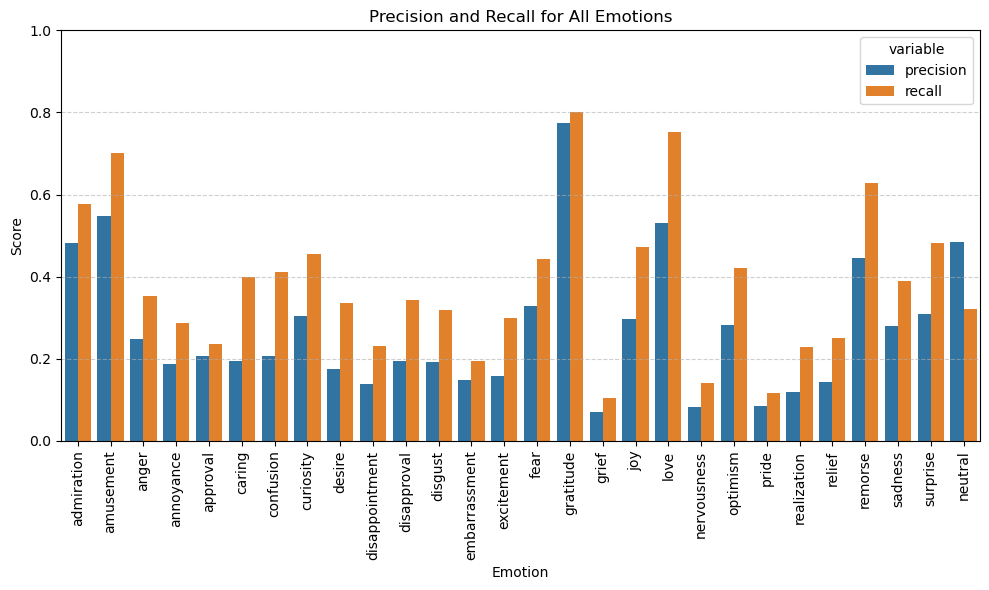

In [ ]:
# Below code is to obtain all precision and recall for the Logistic Regression Model
# Ensure inputs are DataFrames
if isinstance(y_test, np.ndarray):
    y_test_df = pd.DataFrame(y_test, columns=emotion_cols)
else:
    y_test_df = y_test.copy()

if isinstance(y_pred, np.ndarray):
    y_pred_df = pd.DataFrame(y_pred, columns=emotion_cols)
else:
    y_pred_df = y_pred.copy()

# Get precision and recall for all emotions
report_dict = classification_report(
    y_test_df, y_pred_df, target_names=emotion_cols,
    output_dict=True, zero_division=0
)
df_all_metrics = pd.DataFrame(report_dict).T.loc[emotion_cols, ["precision", "recall"]]
df_all_metrics = df_all_metrics.round(4).reset_index().rename(columns={"index": "Emotion"})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_all_metrics.melt(id_vars='Emotion', value_vars=['precision', 'recall']),
    x='Emotion', y='value', hue='variable'
)
plt.title("Precision and Recall for All Emotions")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Storing precision and recall results of Logistic Regression Model
precision_recall_dict_lr_weighted = {
    emotion: {
        "precision": round(metrics["precision"], 4),
        "recall": round(metrics["recall"], 4)
    }
    for emotion, metrics in report_dict.items()
    if emotion in emotion_cols
}

print(precision_recall_dict_lr_weighted)

{'admiration': {'precision': 0.483, 'recall': 0.5765}, 'amusement': {'precision': 0.5481, 'recall': 0.7002}, 'anger': {'precision': 0.2492, 'recall': 0.3528}, 'annoyance': {'precision': 0.188, 'recall': 0.2876}, 'approval': {'precision': 0.2057, 'recall': 0.2359}, 'caring': {'precision': 0.1936, 'recall': 0.3994}, 'confusion': {'precision': 0.2065, 'recall': 0.4109}, 'curiosity': {'precision': 0.3041, 'recall': 0.4551}, 'desire': {'precision': 0.1754, 'recall': 0.335}, 'disappointment': {'precision': 0.1395, 'recall': 0.2301}, 'disapproval': {'precision': 0.1946, 'recall': 0.3438}, 'disgust': {'precision': 0.1921, 'recall': 0.3177}, 'embarrassment': {'precision': 0.1492, 'recall': 0.1957}, 'excitement': {'precision': 0.1571, 'recall': 0.2981}, 'fear': {'precision': 0.3289, 'recall': 0.4431}, 'gratitude': {'precision': 0.7754, 'recall': 0.8}, 'grief': {'precision': 0.0714, 'recall': 0.1034}, 'joy': {'precision': 0.2972, 'recall': 0.4731}, 'love': {'precision': 0.5311, 'recall': 0.7533},

In [ ]:
cm

array([[7394, 1057],
       [2099,  997]])

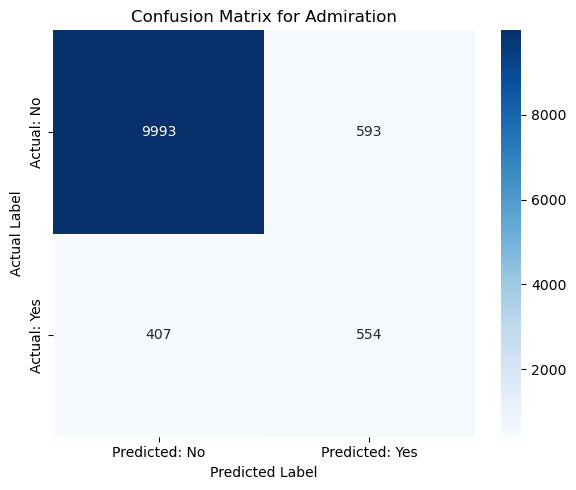

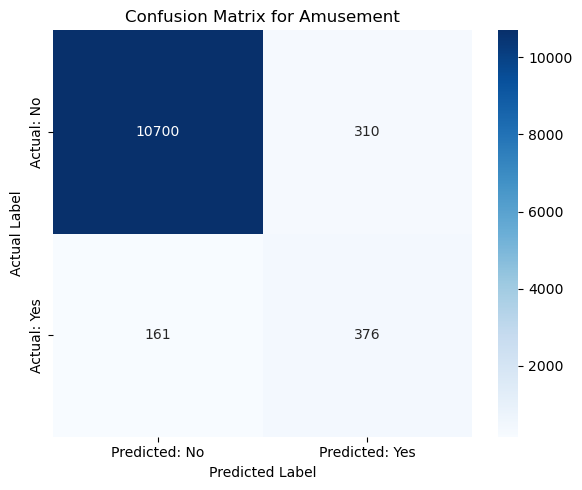

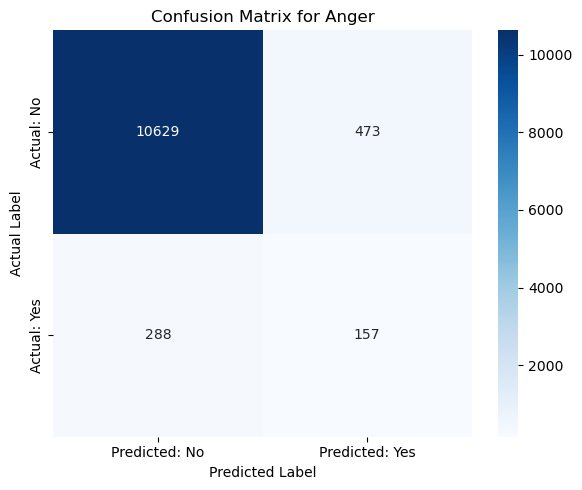

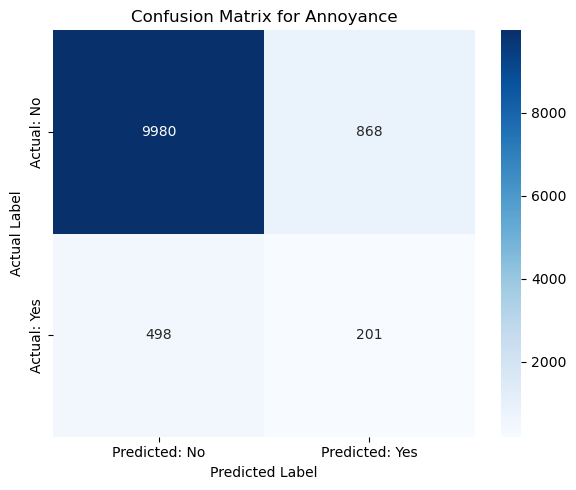

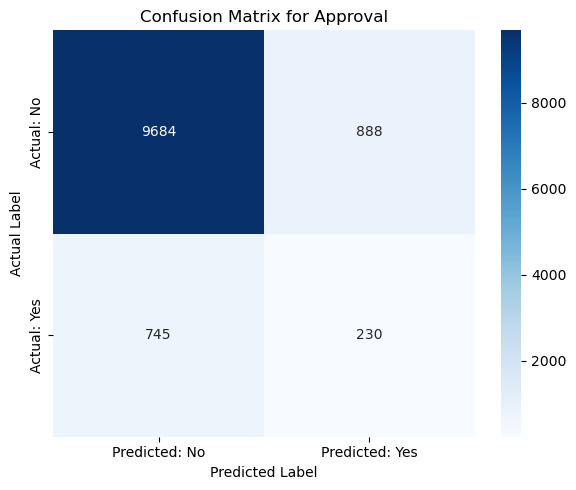

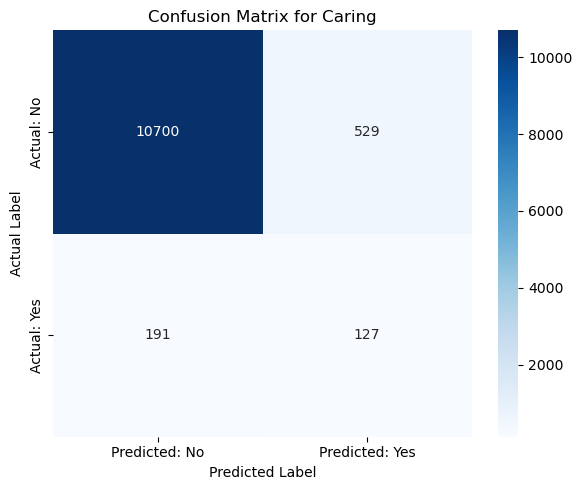

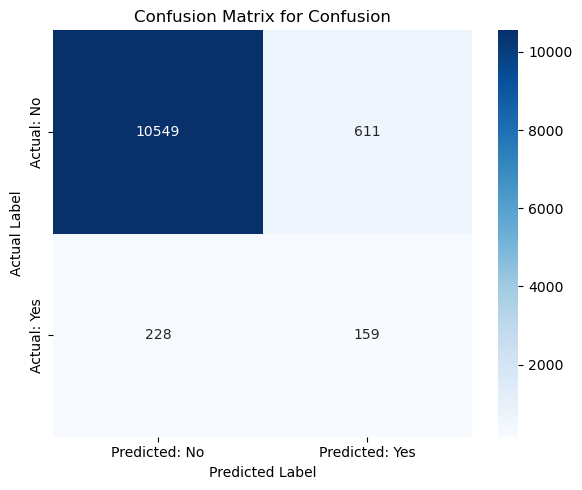

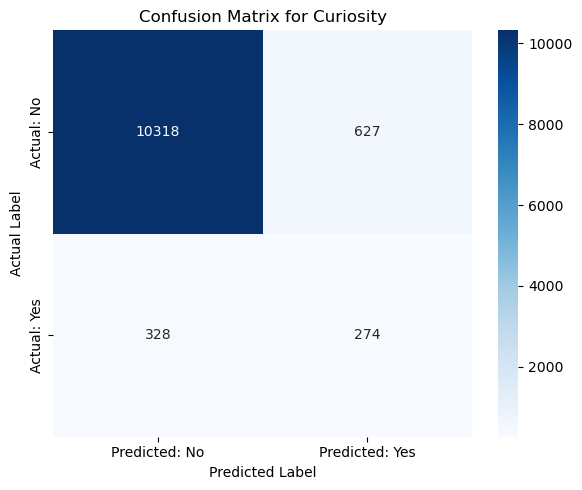

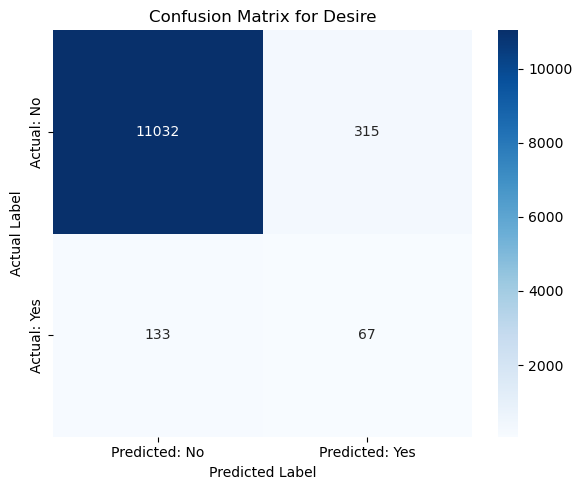

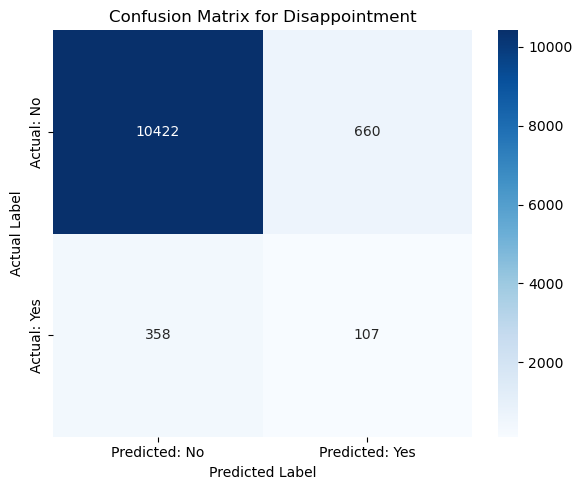

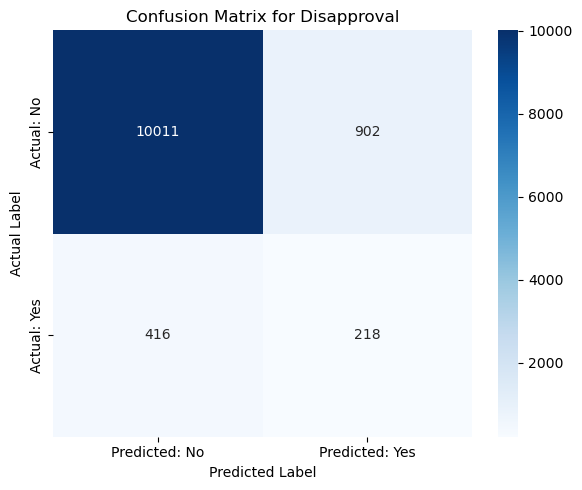

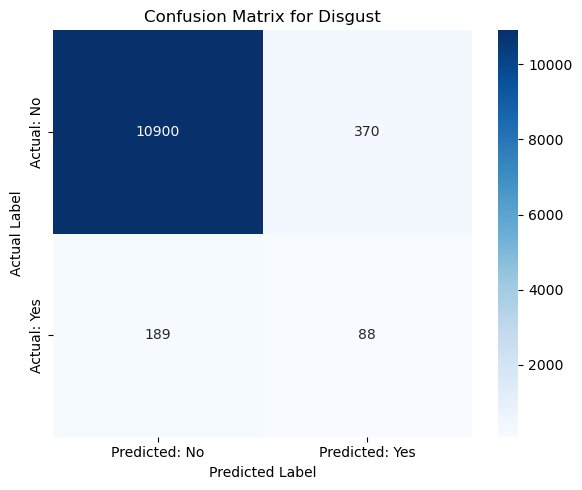

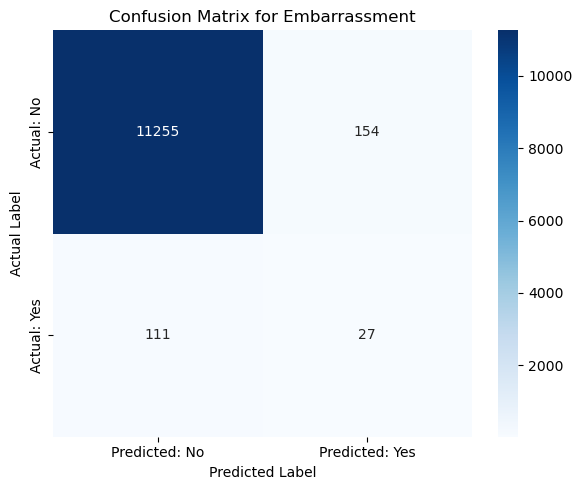

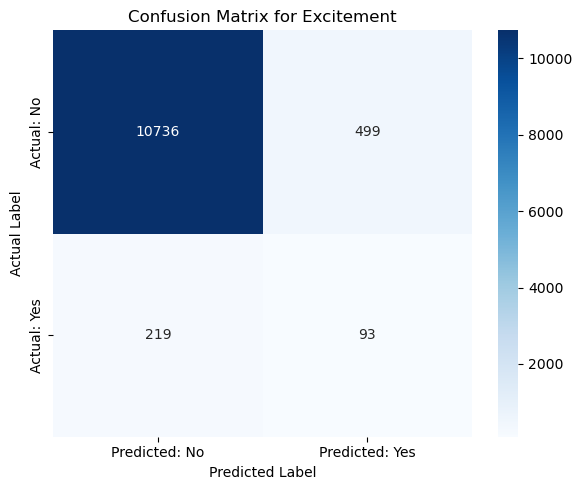

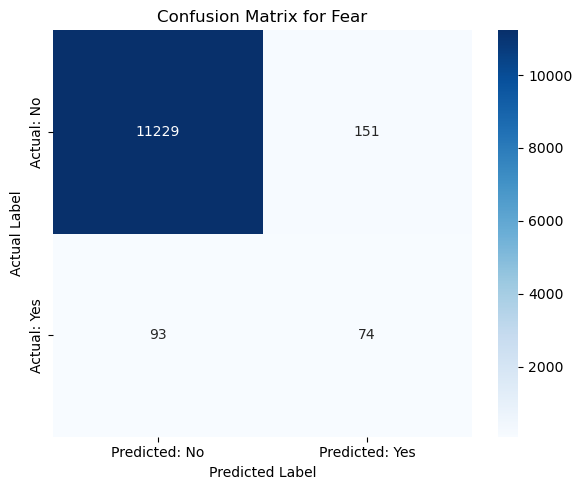

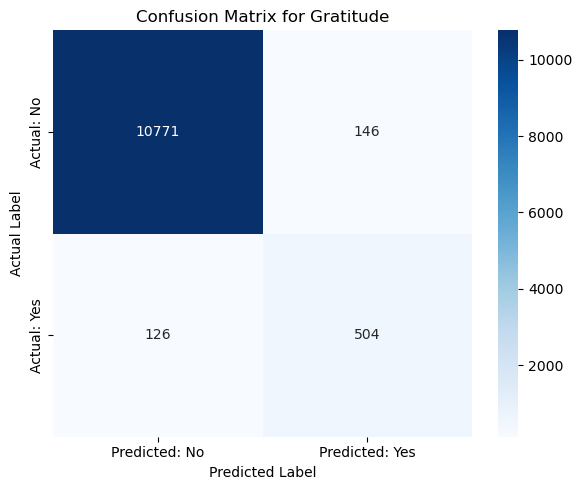

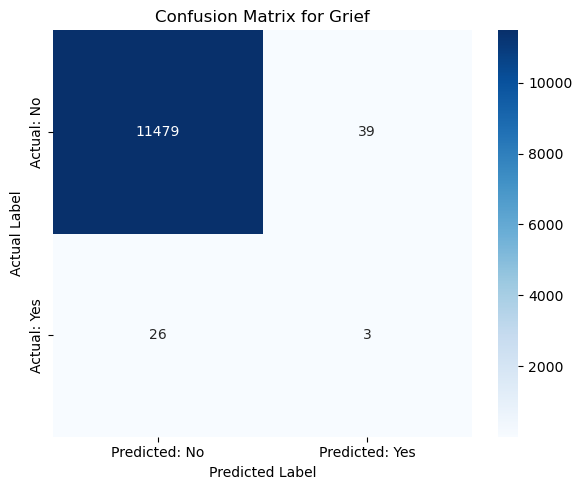

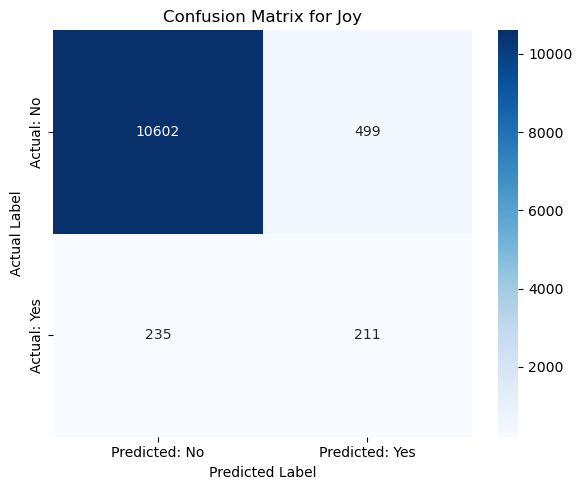

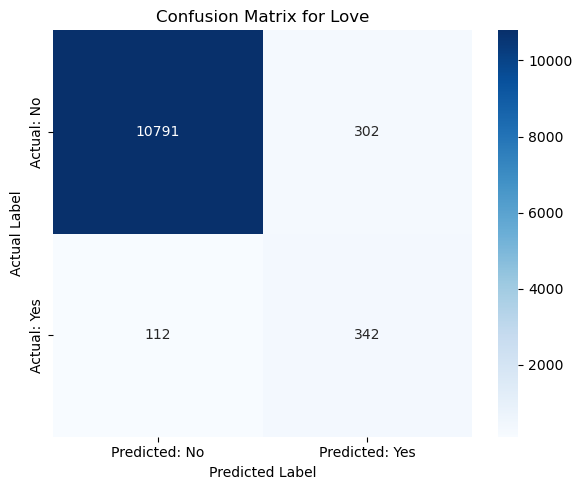

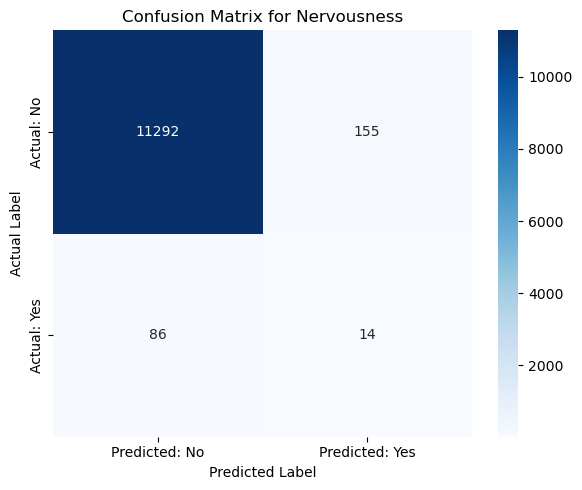

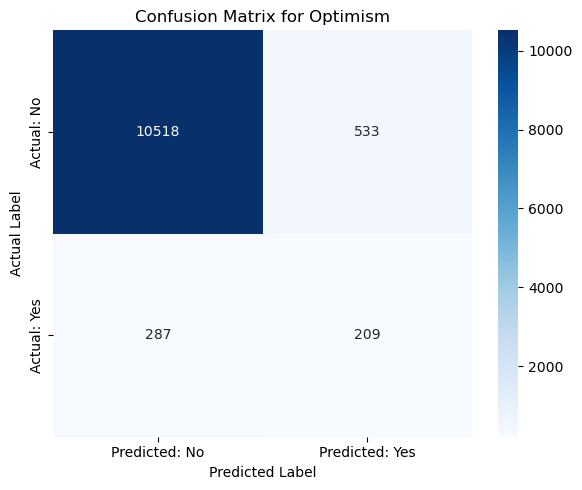

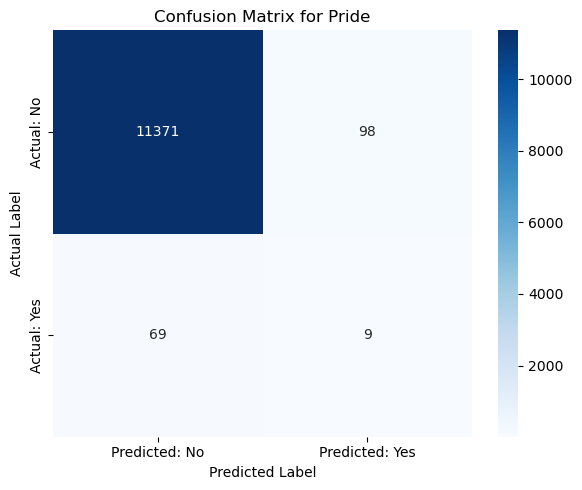

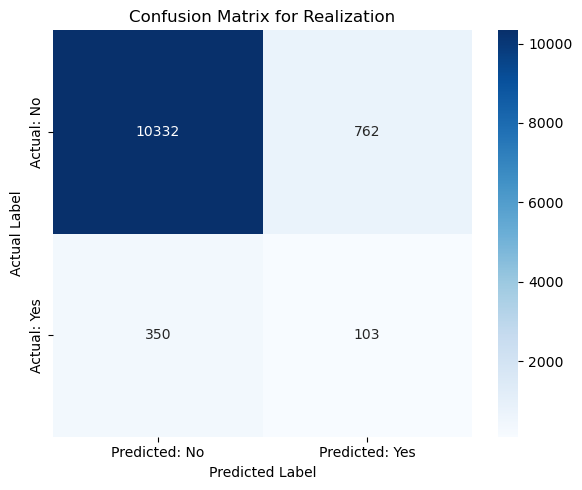

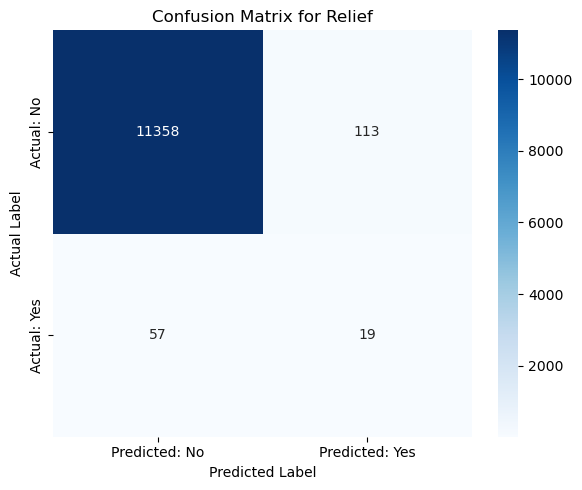

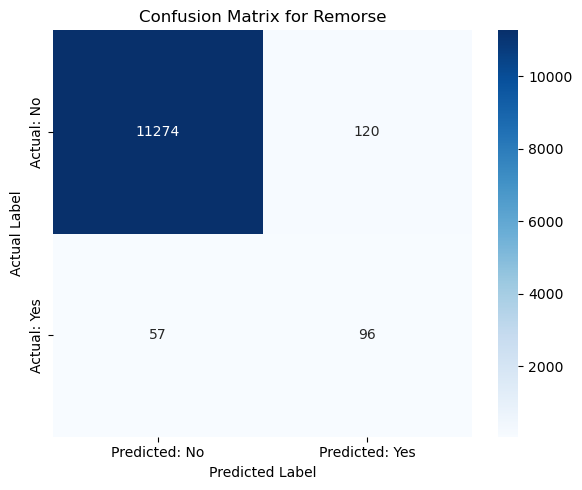

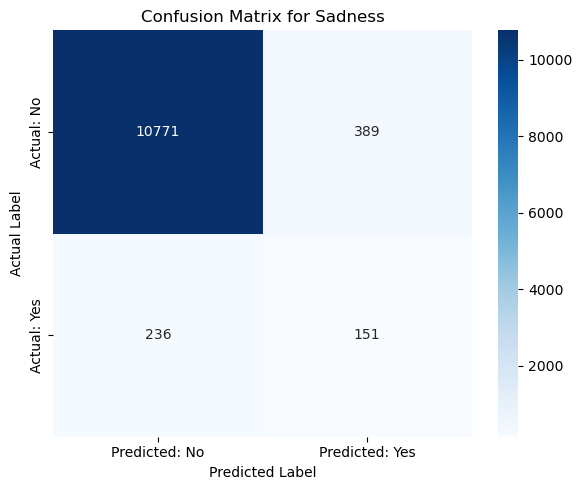

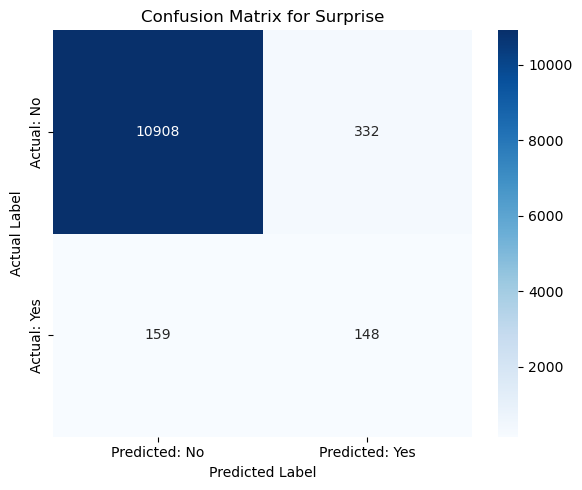

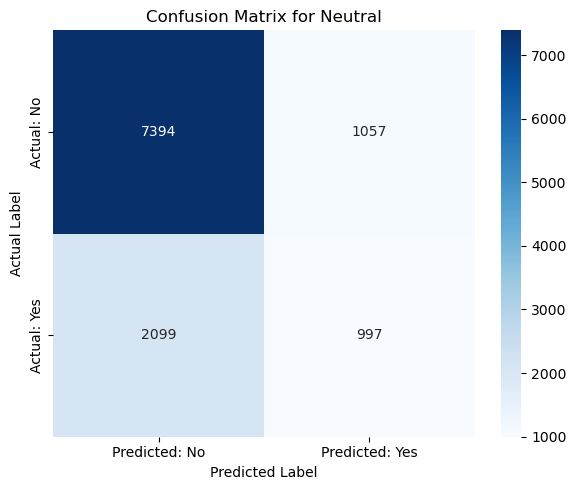

In [ ]:
# Dictionary to store confusion matrices
cm_lr_weighted = {}  
figures = []

for emotion in emotion_cols:
    y_true = y_test_df[emotion]
    y_pred = y_pred_df[emotion]

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_lr_weighted[emotion] = cm  # Store in dictionary

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=["Predicted: No", "Predicted: Yes"],
                yticklabels=["Actual: No", "Actual: Yes"],
                ax=ax)
    ax.set_title(f"Confusion Matrix for {emotion.capitalize()}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

    figures.append(fig)

# Model 2: DistilBERT Model with Pipeline from joeddav

In [ ]:
# Set device to use GPU if detected
device = 0 if torch.cuda.is_available() else -1

# Load pipeline
clf_pipeline = pipeline(
    "text-classification",
    model="joeddav/distilbert-base-uncased-go-emotions-student",
    top_k=2,
    truncation=True,
    device=device
)

Device set to use cpu


In [ ]:
# Run predictions in batches starting with 32
texts = df["clean_text"].tolist()
batch_size = 32

In [ ]:
# Loop through batches and run predictions
top_k_preds = []
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    results = clf_pipeline(batch)
    top_k_preds.extend(results)

  0%|          | 0/1805 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 1805/1805 [12:38<00:00,  2.38it/s]


In [ ]:
# Create multi-hot encoded matrix for Top-2 predictions
emotion_labels = clf_pipeline.model.config.id2label.values()
emotion_to_index = {label: idx for idx, label in enumerate(emotion_labels)}

y_pred_pipeline_multi = np.zeros((len(top_k_preds), len(emotion_labels)))

for i, preds in enumerate(top_k_preds):
    for pred in preds:
        label = pred["label"]
        if label in emotion_to_index:
            y_pred_pipeline_multi[i, emotion_to_index[label]] = 1

In [ ]:
# Convert to DataFrame
df_preds_top2 = pd.DataFrame(y_pred_pipeline_multi, columns=emotion_labels)
df_preds_top2["text"] = df["text"]

In [ ]:
# Get labels from original dataset
y_true = df[emotion_labels].values.astype(int)

# Step 2: Predicted labels from pipeline top-2 (already in multi-hot format)
y_pred_bert_pipe = df_preds_top2[emotion_labels].values.astype(int)

# Step 3: Evaluate multi-label F1 scores
macro_f1 = f1_score(y_true, y_pred_bert_pipe, average="macro", zero_division=0)
micro_f1 = f1_score(y_true, y_pred_bert_pipe, average="micro", zero_division=0)

print(f"Macro F1 (Top-2 Pipeline): {macro_f1:.4f}")
print(f"Micro F1 (Top-2 Pipeline): {micro_f1:.4f}")

Macro F1 (Top-2 Pipeline): 0.2285
Micro F1 (Top-2 Pipeline): 0.2172


In [ ]:
# Store Per Label F1 score, overall F1 score, and Hamming Loss
# Compute classification report
report = classification_report(
    y_true, y_pred_bert_pipe,
    target_names=list(emotion_labels),
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).T

# Per-label F1
per_label_f1_BERT_pipeline = report_df.loc[list(emotion_labels), ['f1-score']]

# Per-label Precision & Recall
per_label_precision_recall_BERT_pipeline = report_df.loc[list(emotion_labels), ['precision', 'recall']]

# Overall metrics
macro_f1 = f1_score(y_true, y_pred_bert_pipe, average="macro", zero_division=0)
micro_f1 = f1_score(y_true, y_pred_bert_pipe, average="micro", zero_division=0)
hamming = hamming_loss(y_true, y_pred_bert_pipe)

overall_f1_scores_BERT_pipeline = [{
    "Model": "DistilBERT_Top2_Pipeline",
    "Macro F1": round(macro_f1, 4),
    "Micro F1": round(micro_f1, 4),
    "Hamming Loss": round(hamming, 4)
}]

# Confusion matrices for each label
if isinstance(y_true, np.ndarray):
    y_true_df = pd.DataFrame(y_true, columns=emotion_labels)
else:
    y_true_df = y_true.copy()

if isinstance(y_pred_bert_pipe, np.ndarray):
    y_pred_bert_pipe_df = pd.DataFrame(y_pred_bert_pipe, columns=emotion_labels)
else:
    y_pred_bert_pipe_df = y_pred_bert_pipe.copy()

# Ensure DataFrame views
y_true_df = pd.DataFrame(y_true, columns=emotion_labels)
y_pred_df = pd.DataFrame(y_pred_bert_pipe, columns=emotion_labels)

# Confusion matrices per label
cm_BERT_pipeline = {
    emotion: confusion_matrix(y_true_df[emotion].values, y_pred_df[emotion].values)
    for emotion in emotion_labels
}

print("Per-label F1 scores:\n", per_label_f1_BERT_pipeline.head())
print("\nPer-label Precision & Recall:\n", per_label_precision_recall_BERT_pipeline.head())
print("\nOverall metrics:\n", overall_f1_scores_BERT_pipeline)

Per-label F1 scores:
             f1-score
admiration  0.363571
amusement   0.473843
anger       0.193829
annoyance   0.197057
approval    0.135213

Per-label Precision & Recall:
             precision    recall
admiration   0.436306  0.311621
amusement    0.381139  0.626136
anger        0.172293  0.221519
annoyance    0.152099  0.279746
approval     0.160158  0.116990

Overall metrics:
 [{'Model': 'DistilBERT_Top2_Pipeline', 'Macro F1': 0.2285, 'Micro F1': 0.2172, 'Hamming Loss': 0.0892}]


# Model 3: BERT Embeddings with Logistic Regression

In [ ]:
# Load BERT tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
bert_model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
# Create function to extract CLS embeddings
def get_cls_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = bert_model(**tokens)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings.cpu().numpy())
    return np.vstack(embeddings)

In [ ]:
# Preparing Data and computing the embeddings
texts = df["clean_text"].tolist()
y = df[emotion_cols].values

X_train_texts, X_test_texts, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)

X_train_embeds = get_cls_embeddings(X_train_texts)
X_test_embeds = get_cls_embeddings(X_test_texts)

In [ ]:
# Applying SBERT encodings
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
X_train_sbert = sbert_model.encode(X_train_texts, show_progress_bar=True)
X_test_sbert  = sbert_model.encode(X_test_texts,  show_progress_bar=True)

# Concatenate CLS + SBERT features
X_train_combined = np.hstack([X_train_embeds, X_train_sbert])
X_test_combined  = np.hstack([X_test_embeds,  X_test_sbert])

# Train classifier
clf_combined = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, class_weight="balanced")
)
clf_combined.fit(X_train_combined, y_train)

# Predict with threshold = 0.65
threshold = 0.65
y_proba = clf_combined.predict_proba(X_test_combined)
y_pred  = (y_proba >= threshold).astype(int)

# Overall metrics
macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
micro_f1 = f1_score(y_test, y_pred, average="micro", zero_division=0)
hamming  = hamming_loss(y_test, y_pred)

print(f"Threshold: {threshold}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1444 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Batches:   0%|          | 0/361 [00:00<?, ?it/s]

Threshold: 0.65
Macro F1: 0.2565
Micro F1: 0.2901
Hamming Loss: 0.1110


In [ ]:
# Store Per-label metrics split (F1 vs Prec/Rec)
report = classification_report(
    y_test, y_pred, target_names=emotion_cols, output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report).T
per_label_f1 = report_df.loc[emotion_cols, ["f1-score"]]
per_label_precision_recall = report_df.loc[emotion_cols, ["precision", "recall"]]

# 7) Store results in tidy variables/dicts
model_name = f"CLS+SBERT_LR_Weighted_{threshold:.2f}"

per_label_f1_SBERT_LR_Weighted = { model_name: per_label_f1 }
per_label_precision_recall_SBERT_LR_Weighted = { model_name: per_label_precision_recall }

overall_f1_scores_CLS_SBERT_LR_Weighted = [{
    "Model": model_name,
    "Macro F1": round(macro_f1, 4),
    "Micro F1": round(micro_f1, 4),
    "Hamming Loss": round(hamming, 4)
}]

# 8) Per-label confusion matrices
y_test_df = pd.DataFrame(y_test, columns=emotion_cols)
y_pred_df = pd.DataFrame(y_pred, columns=emotion_cols)
cm_SBERT_LR_Weighted = {
    emotion: confusion_matrix(y_test_df[emotion].values, y_pred_df[emotion].values)
    for emotion in emotion_cols
}

# Model 4: BERT Embeddings with XGBoost Classifier

In [ ]:
# Train Test Split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["clean_text"], df[emotion_cols],
    test_size=0.2, random_state=42
)

# Load BERT tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
bert_model.eval()

# Function to get CLS embeddings
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, truncation=True, padding=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = bert_model(**encodings)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

# Generate embeddings
X_train_embed = get_bert_embeddings(X_train_text.tolist())
X_test_embed = get_bert_embeddings(X_test_text.tolist())

In [ ]:
# Define parameter grid
learning_rates = [0.05, 0.1, 0.2]
n_estimators_list = [50, 100, 150]

# Track best model and scores
best_score = 0
best_params = {}
results_grid = []

# Run grid search
for lr in learning_rates:
    for n_est in n_estimators_list:
        y_pred_grid = []
        xgb_models_grid = []

        for i, label_name in enumerate(emotion_cols):
            # Compute class weights
            weights = compute_class_weight(
                class_weight='balanced',
                classes=np.array([0, 1]),
                y=y_train.iloc[:, i]
            )
            scale_pos_weight = weights[1] / weights[0]

            # Train model
            model = XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                learning_rate=lr,
                max_depth=6,
                n_estimators=n_est,
                verbosity=0
            )
            model.fit(X_train_embed, y_train.iloc[:, i])
            preds = model.predict(X_test_embed)
            y_pred_grid.append(preds)
            xgb_models_grid.append(model)

        # Stack predictions
        y_pred_grid = np.array(y_pred_grid).T

        # Evaluate
        macro_f1 = f1_score(y_test, y_pred_grid, average='macro', zero_division=0)
        micro_f1 = f1_score(y_test, y_pred_grid, average='micro', zero_division=0)
        results_grid.append({
            'learning_rate': lr,
            'n_estimators': n_est,
            'Macro F1': macro_f1,
            'Micro F1': micro_f1
        })

        if macro_f1 > best_score:
            best_score = macro_f1
            best_params = {
                'learning_rate': lr,
                'n_estimators': n_est,
                'Macro F1': macro_f1,
                'Micro F1': micro_f1
            }

In [ ]:
# Assign the best params from grid search
best_params = {'learning_rate': 0.05, 'n_estimators': 150}

results = []

# Apply iterative stratification on training set
stratifier = IterativeStratification(n_splits=5, order=1)

y_train_array = y_train.values if isinstance(y_train, pd.DataFrame) else y_train

for fold, (train_idx, val_idx) in enumerate(stratifier.split(X_train_embed, y_train_array)):
    X_fold_train, X_fold_val = X_train_embed[train_idx], X_train_embed[val_idx]
    y_fold_train, y_fold_val = y_train_array[train_idx], y_train_array[val_idx]

    y_val_preds = []
    for i in range(y_train.shape[1]):
        pos = np.sum(y_fold_train[:, i])
        neg = len(y_fold_train) - pos
        scale = (neg / pos) if pos > 0 else 1

        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=scale,
            learning_rate=best_params['learning_rate'],
            n_estimators=best_params['n_estimators'],
            verbosity=0
        )
        model.fit(X_fold_train, y_fold_train[:, i])
        preds = model.predict(X_fold_val)
        y_val_preds.append(preds)

    y_val_preds = np.array(y_val_preds).T
    macro_f1 = f1_score(y_fold_val, y_val_preds, average='macro', zero_division=0)
    micro_f1 = f1_score(y_fold_val, y_val_preds, average='micro', zero_division=0)
    results.append({'Fold': fold + 1, 'Macro F1': macro_f1, 'Micro F1': micro_f1})

# View results
pd.DataFrame(results)

,Fold,Macro F1,Micro F1
0,1,0.260605,0.335790
1,2,0.252312,0.326658
2,3,0.249494,0.334478
3,4,0.253406,0.330343
4,5,0.251064,0.329341


In [ ]:
# Storage for per-label metrics
per_label_f1_folds = []
per_label_pr_folds = []

for fold, (train_idx, val_idx) in enumerate(stratifier.split(X_train_embed, y_train_array)):
    X_fold_train, X_fold_val = X_train_embed[train_idx], X_train_embed[val_idx]
    y_fold_train, y_fold_val = y_train_array[train_idx], y_train_array[val_idx]

    y_val_preds = []
    for i in range(y_train.shape[1]):
        pos = np.sum(y_fold_train[:, i])
        neg = len(y_fold_train) - pos
        scale = (neg / pos) if pos > 0 else 1

        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=scale,
            learning_rate=best_params['learning_rate'],
            n_estimators=best_params['n_estimators'],
            verbosity=0
        )
        model.fit(X_fold_train, y_fold_train[:, i])
        preds = model.predict(X_fold_val)
        y_val_preds.append(preds)

    y_val_preds = np.array(y_val_preds).T

    # --- collect per-label metrics ---
    rep = classification_report(
        y_fold_val, y_val_preds,
        target_names=emotion_cols,
        output_dict=True,
        zero_division=0
    )
    rep_df = pd.DataFrame(rep).T.loc[emotion_cols, ['precision', 'recall', 'f1-score']]

    per_label_f1_folds.append(rep_df[['f1-score']])
    per_label_pr_folds.append(rep_df[['precision', 'recall']])

    macro_f1 = f1_score(y_fold_val, y_val_preds, average='macro', zero_division=0)
    micro_f1 = f1_score(y_fold_val, y_val_preds, average='micro', zero_division=0)
    results.append({'Fold': fold + 1, 'Macro F1': macro_f1, 'Micro F1': micro_f1})

# --- aggregate after loop ---
df_results = pd.DataFrame(results)

per_label_f1_XGB = pd.concat(per_label_f1_folds, axis=1).mean(axis=1).to_frame('f1-score')
precision_mean = pd.concat([d['precision'] for d in per_label_pr_folds], axis=1).mean(axis=1)
recall_mean    = pd.concat([d['recall'] for d in per_label_pr_folds], axis=1).mean(axis=1)
per_label_precision_recall_XGB = pd.DataFrame({'precision': precision_mean, 'recall': recall_mean})

overall_f1_scores_XGB = [{
    "Model": f"XGB_CV_lr{best_params['learning_rate']}_ne{best_params['n_estimators']}",
    "Macro F1": round(df_results['Macro F1'].mean(), 4),
    "Micro F1": round(df_results['Micro F1'].mean(), 4)
}]

# Optional: print to verify
print(per_label_f1_XGB.head())
print(per_label_precision_recall_XGB.head())
print(overall_f1_scores_XGB)

            f1-score
admiration  0.450282
amusement   0.459926
anger       0.303082
annoyance   0.228997
approval    0.218200
            precision    recall
admiration   0.363295  0.592258
amusement    0.399255  0.544459
anger        0.226470  0.458386
annoyance    0.159857  0.403678
approval     0.174844  0.290192
[{'Model': 'XGB_CV_lr0.05_ne150', 'Macro F1': 0.2539, 'Micro F1': 0.332}]


In [ ]:

# Function to change results to series
def to_f1_series(obj, key=None):
    """Return a per-label F1 Series from either a dict or DataFrame."""
    if isinstance(obj, dict):
        if key is not None:
            df = obj[key]
        elif len(obj) == 1:
            df = next(iter(obj.values()))
        else:
            raise KeyError(f"Multiple keys in dict; specify key. Available: {list(obj.keys())}")
    else:
        df = obj

    # Normalize to a Series named 'f1-score'
    if isinstance(df, pd.Series):
        s = df.copy()
    else:
        s = df['f1-score'] if 'f1-score' in df.columns else df.iloc[:, 0]
    return s

# Build Series for each model
s_lr      = to_f1_series(threshold_reports_lr_weighted, key="LogReg_Weighted_0.65")
s_bertpip = to_f1_series(per_label_f1_BERT_pipeline)  
s_sbertlr = to_f1_series(per_label_f1_SBERT_LR_Weighted, key="CLS+SBERT_LR_Weighted_0.65")
s_xgb = to_f1_series(per_label_f1_XGB)

# Combine
df_per_label_f1_all = (
    pd.concat([
        s_lr.rename("LogReg_Weighted_0.65"),
        s_bertpip.rename("BERT_Pipeline_Top2"),
        s_sbertlr.rename("BERT_Embed_LR_Weighted_0.65"),
        s_xgb.rename("XGBoost_BERT_Embed"),
    ], axis=1)
    .reindex(emotion_cols)
    .round(4)
)

print(df_per_label_f1_all.head())

            LogReg_Weighted_0.65  BERT_Pipeline_Top2  \
admiration                0.5256              0.3636   
amusement                 0.6149              0.4738   
anger                     0.2921              0.1938   
annoyance                 0.2274              0.1971   
approval                  0.2198              0.1352   

            BERT_Embed_LR_Weighted_0.65  XGBoost_BERT_Embed  
admiration                       0.4884              0.4503  
amusement                        0.5139              0.4599  
anger                            0.2677              0.3031  
annoyance                        0.2416              0.2290  
approval                         0.2481              0.2182  


In [ ]:
# Add column for model with highest F1 score per emotion
df_per_label_f1_all["Best Model"] = df_per_label_f1_all.idxmax(axis=1)

# Display
display(df_per_label_f1_all)

,LogReg_Weighted_0.65,BERT_Pipeline_Top2,BERT_Embed_LR_Weighted_0.65,XGBoost_BERT_Embed,Best F1,Best Model
admiration,0.5256,0.3636,0.4884,0.4503,0.5256,LogReg_Weighted_0.65
amusement,0.6149,0.4738,0.5139,0.4599,0.6149,LogReg_Weighted_0.65
anger,0.2921,0.1938,0.2677,0.3031,0.3031,XGBoost_BERT_Embed
annoyance,0.2274,0.1971,0.2416,0.2290,0.2416,BERT_Embed_LR_Weighted_0.65
approval,0.2198,0.1352,0.2481,0.2182,0.2481,BERT_Embed_LR_Weighted_0.65
caring,0.2608,0.1139,0.2103,0.2685,0.2685,XGBoost_BERT_Embed
confusion,0.2748,0.1744,0.2295,0.2292,0.2748,LogReg_Weighted_0.65
curiosity,0.3646,0.2504,0.3597,0.3277,0.3646,LogReg_Weighted_0.65
desire,0.2302,0.1861,0.1594,0.1837,0.2302,LogReg_Weighted_0.65
disappointment,0.1737,0.1806,0.1896,0.1546,0.1896,BERT_Embed_LR_Weighted_0.65


In [ ]:
df_per_label_f1_all_sorted = df_per_label_f1_all.sort_values(by="Best Model")
display(df_per_label_f1_all_sorted)

,LogReg_Weighted_0.65,BERT_Pipeline_Top2,BERT_Embed_LR_Weighted_0.65,XGBoost_BERT_Embed,Best F1,Best Model
annoyance,0.2274,0.1971,0.2416,0.2290,0.2416,BERT_Embed_LR_Weighted_0.65
approval,0.2198,0.1352,0.2481,0.2182,0.2481,BERT_Embed_LR_Weighted_0.65
disappointment,0.1737,0.1806,0.1896,0.1546,0.1896,BERT_Embed_LR_Weighted_0.65
sadness,0.3258,0.3491,0.2641,0.2585,0.3491,BERT_Pipeline_Top2
pride,0.0973,0.1205,0.0539,0.0856,0.1205,BERT_Pipeline_Top2
nervousness,0.1041,0.1445,0.0686,0.0832,0.1445,BERT_Pipeline_Top2
fear,0.3776,0.3933,0.2171,0.2364,0.3933,BERT_Pipeline_Top2
admiration,0.5256,0.3636,0.4884,0.4503,0.5256,LogReg_Weighted_0.65
remorse,0.5203,0.2996,0.2990,0.3053,0.5203,LogReg_Weighted_0.65
relief,0.1827,0.1251,0.0672,0.0318,0.1827,LogReg_Weighted_0.65


In [ ]:

distressed_emotions = [
    "annoyance","disapproval","disappointment","fear","grief",
    "nervousness","sadness","disgust","embarrassment","remorse","anger"
]

# subset to distressed emotions (keep order first)
tbl = df_per_label_f1_all.reindex(distressed_emotions)

# use only numeric columns
tbl_num = tbl.select_dtypes(include=[np.number])

# compute best model + score
tbl["Best Model"] = tbl_num.idxmax(axis=1)
tbl["F1 Score"]  = tbl_num.max(axis=1).round(4)

# prepare final DataFrame
top_distressed = (
    tbl[["Best Model","F1 Score"]]
      .rename_axis("Emotion")
      .reset_index()
      .sort_values(by=["Best Model","F1 Score"], ascending=[True, False])  # ✅ sort by best model then score
)

display(top_distressed)


,Emotion,Best Model,F1 Score
0,annoyance,BERT_Embed_LR_Weighted_0.65,0.2416
2,disappointment,BERT_Embed_LR_Weighted_0.65,0.1896
3,fear,BERT_Pipeline_Top2,0.3933
6,sadness,BERT_Pipeline_Top2,0.3491
5,nervousness,BERT_Pipeline_Top2,0.1445
9,remorse,LogReg_Weighted_0.65,0.5203
1,disapproval,LogReg_Weighted_0.65,0.2486
7,disgust,LogReg_Weighted_0.65,0.2395
8,embarrassment,LogReg_Weighted_0.65,0.1693
10,anger,XGBoost_BERT_Embed,0.3031


In [ ]:
# Wrap DataFrames in dicts with model name as key
per_label_precision_recall_XGB = {
    "XGBoost_BERT_Embed": per_label_precision_recall_XGB
}

per_label_precision_recall_BERT_pipeline = {
    "BERT_Pipeline_Top2": per_label_precision_recall_BERT_pipeline
}

In [139]:
#  Extract precision/recall rows for given emotions from a dict
def pick_pr(pr_dict, model_key, emotions):

    df_pr = pr_dict[model_key].copy()
    df_pr = df_pr.rename_axis("Emotion").reset_index()
    out = df_pr[df_pr["Emotion"].isin(emotions)][["Emotion", "precision", "recall"]]
    out["Model"] = model_key
    out = out.set_index("Emotion").loc[emotions].reset_index()
    return out

# Define which emotions to pull from which models
from_lr_065_1 = ["annoyance", "disappointment"]
from_pipe_top2 = ["fear", "sadness", "nervousness"]
from_lr_065_2 = ["remorse", "disapproval", "disgust", "embarrassment"]
from_xgb = ["anger", "grief"]

# LR Weighted
pr_lr = pr_from_dict(precision_recall_dict_lr_weighted, from_lr_065_1, "LogReg_Weighted_0.65")

# BERT pipeline top-2
pr_pipe = pick_pr(per_label_precision_recall_BERT_pipeline, "BERT_Pipeline_Top2", from_pipe_top2)

# XGBoost
pr_xgb = pick_pr(per_label_precision_recall_XGB, "XGBoost_BERT_Embed", from_xgb)

# SBERT
pr_SBERT_lr = pick_pr(per_label_precision_recall_SBERT_LR_Weighted, "CLS+SBERT_LR_Weighted_0.65", from_lr_065_2)

# Combine
selected_pr = pd.concat([pr_lr, pr_pipe, pr_xgb, pr_SBERT_lr], ignore_index=True)

display(selected_pr)

,Emotion,Model,precision,recall
0,annoyance,LogReg_Weighted_0.65,0.188000,0.287600
1,disappointment,LogReg_Weighted_0.65,0.139500,0.230100
2,fear,BERT_Pipeline_Top2,0.356682,0.438279
3,sadness,BERT_Pipeline_Top2,0.261710,0.524277
4,nervousness,BERT_Pipeline_Top2,0.090524,0.358491
5,anger,XGBoost_BERT_Embed,0.226470,0.458386
6,grief,XGBoost_BERT_Embed,0.255769,0.074483
7,remorse,CLS+SBERT_LR_Weighted_0.65,0.192164,0.673203
8,disapproval,CLS+SBERT_LR_Weighted_0.65,0.161765,0.520505
9,disgust,CLS+SBERT_LR_Weighted_0.65,0.104000,0.516245


In [121]:
def pr_from_dict(pr_dict, emotions, model_name):
    """Select precision/recall rows from a dict-of-dicts and tag with model."""
    df = pd.DataFrame.from_dict(pr_dict, orient="index")[["precision","recall"]]
    out = df.loc[emotions].reset_index().rename(columns={"index":"Emotion"})
    out["Model"] = model_name
    return out[["Emotion","Model","precision","recall"]]

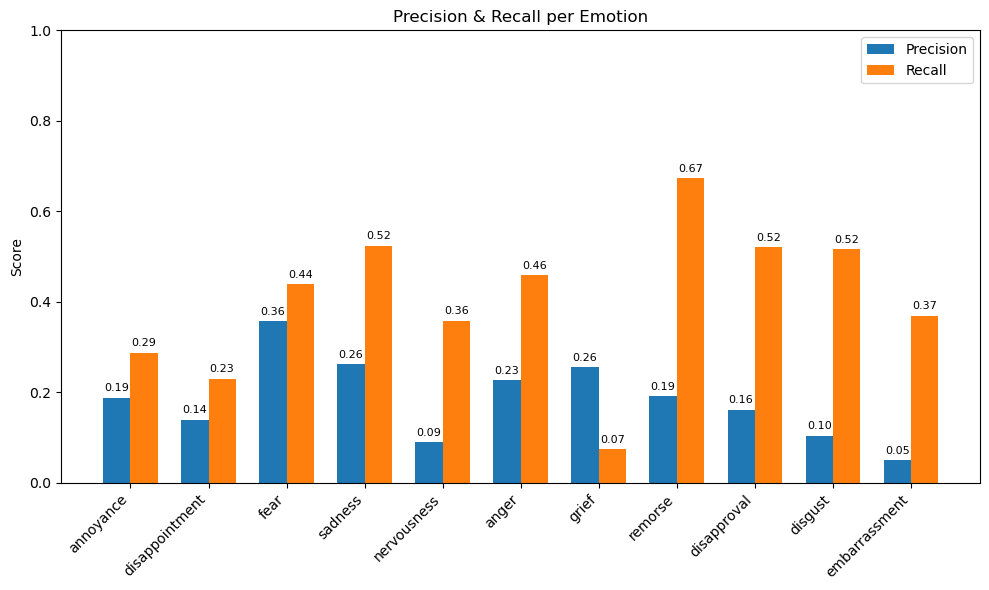

In [140]:

# Plot setup
x = np.arange(len(selected_pr["Emotion"]))  # positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Precision and Recall bars
bars1 = ax.bar(x - width/2, selected_pr["precision"], width, label="Precision")
bars2 = ax.bar(x + width/2, selected_pr["recall"], width, label="Recall")

# Labels & styling
ax.set_ylabel("Score")
ax.set_title("Precision & Recall per Emotion")
ax.set_xticks(x)
ax.set_xticklabels(selected_pr["Emotion"], rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()
